In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/jovyan/work')
import os
os.environ["DASK_DISTRIBUTED__DIAGNOSTICS__NVML"] = "False"

import logging
import segyio
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.signal import butter, sosfilt

from devito import *
from copy import deepcopy
from distributed import Client, wait, LocalCluster

from devito_ta.model_geom import get_model, get_geometry, grad_utils
from devito_ta.simulation import fm_multi_shots, grad_multi_shots
from devito_ta.plotting import plot_shotrecord_cust, plot_velocity_cust, plot_acquisition_geometry, plot_freq

configuration['log-level'] = 'WARNING'
configuration['opt'] = 'advanced'
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

In [ ]:
file = 'vp_marmousi-ii_10m.segy'

with segyio.open(file, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:] 

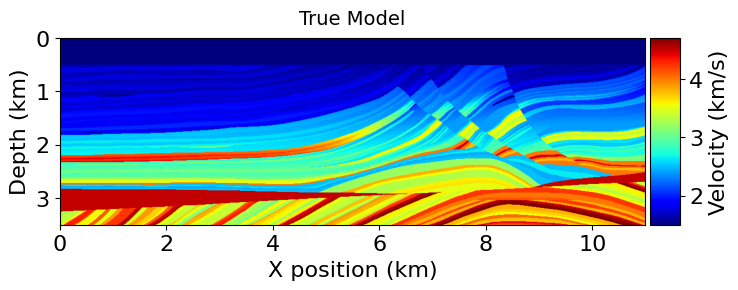

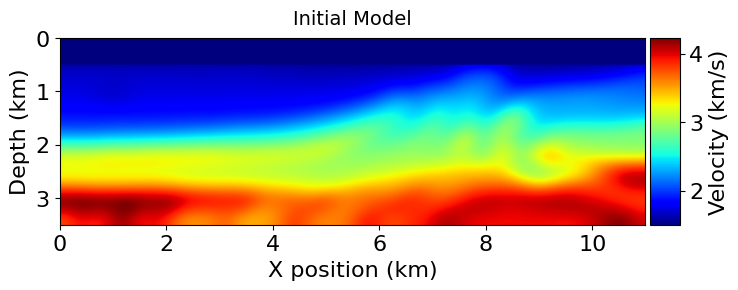

In [3]:
# Define water bottom depth in grid
wb = 50

# Define the model
v = data[200:1300, wb:].copy()             # Remove water layer

# Add water bottom to initial model
water_btm = np.ones((v.shape[0], wb)) * 1.5
v = np.concatenate([water_btm, v], axis=1)
minv = v.min()
maxv = v.max()

# Create initial model
init = gaussian_filter(v, sigma=[20, 20])  
init[:, :wb] = water_btm

init = np.clip(init, a_min=1.5, a_max=4.5)

# Get model

shape = (1100, 351)
spacing = (10, 10)
origin = (0, 0)

model1 = get_model(np.clip(v, 1.5, 5), shape, spacing, origin)
model0 = get_model(init, shape, spacing, origin)

# Plot velocity model
plot_velocity_cust(model1, colorbar=True, save=False, title='True Model', name='true_model')
plot_velocity_cust(model0, colorbar=True, save=False, title='Initial Model', name='init_model')


In [4]:
model1.critical_dt

np.float32(1.18)

In [5]:
# Create new geometry for 30 shots
par = {'nx':1100,          'dx':10,       'ox':0,
       'nz':351,          'dz':10,       'oz':0,
       'ns':30,           'ds':300,      'os':2020.0,  'sz':0,
       'nr':200,          'dr':10.0,     'or':0,       'rz':0,
       'nt':4000,         'dt':1.18,        'ot':0,       'nof':20,
       'freq':5,
      }

# Sampling frequency
fs = 1 / (par['dt']/1000)
nbl = model1.nbl

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz'] 

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz'] 

geometry1 = get_geometry(model=model1,
                         src_x=x_s[:, 0],
                         src_z=x_s[:, 1],
                         rec_x=x_r[:, 0],
                         rec_z=x_r[:, 1],
                         t0=0,
                         tn=par['nt'],
                         nof=par['nof'],
                         src_type='Ricker',
                         f0=par['freq']/1000,
                         dt=par['dt'])


n_workers = 6

cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit='auto',
    threads_per_worker=4,
    death_timeout=3600
)

client = Client(cluster)
client.restart()

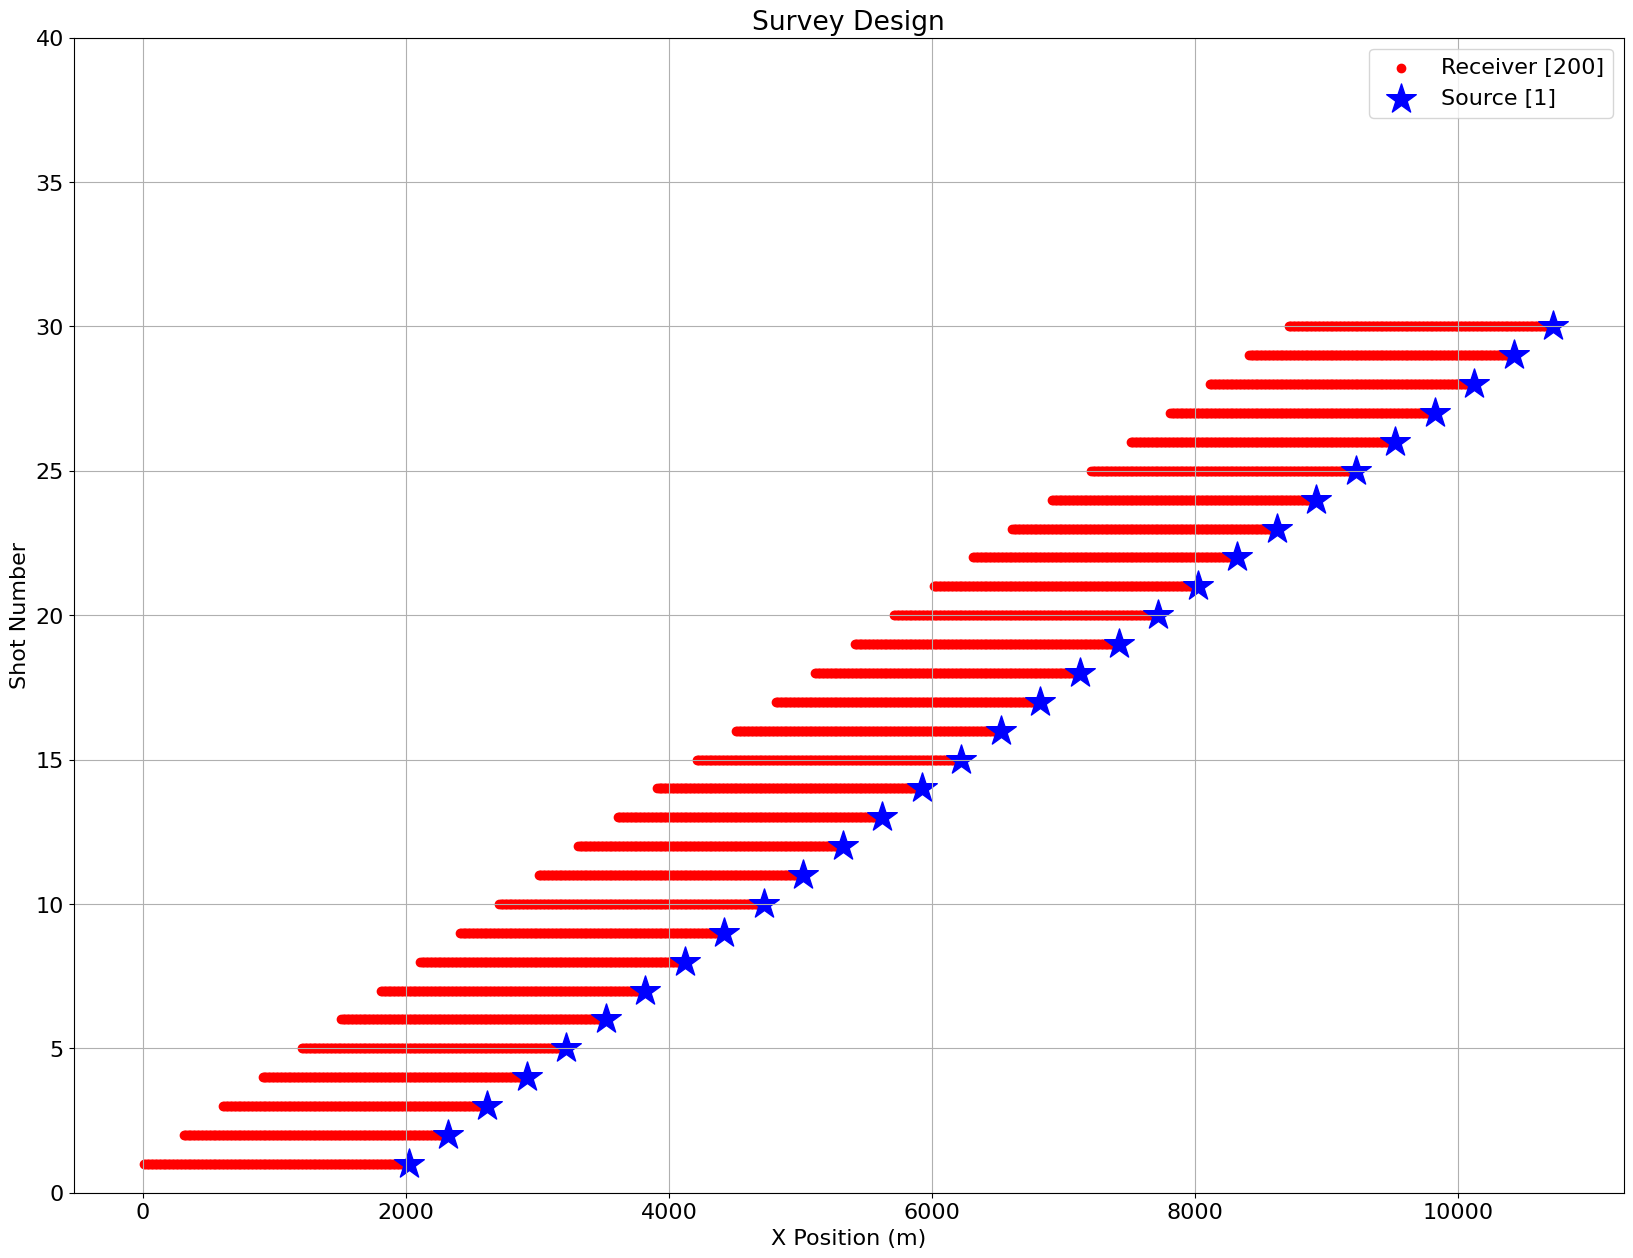

In [7]:
plot_acquisition_geometry(geometry1, 'Survey Design')

In [8]:
# Perform forward modelling at 5 Hz
dt = par['dt']

start_5hz = time.time()
fm = fm_multi_shots(model1, geometry1, n_workers, client, dt=dt)
finish_5hz = time.time()

duration_5hz = finish_5hz - start_5hz
print(f'Forward modelling duration for 30 shots: {(duration_5hz/60):.2f} minutes')

Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.42 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.45 s
Operator `Forward` ran in 1.44 s
Operator `Forward` ran in 1.42 s
Operator `Forward` ran in 1.43 s
Operator `Forward` ran in 1.46 s
Operator `Forward` ran in 1.59 s
Operator `Forward` ran in 1.53 s
Operator `Forward` ran in 1.42 s
Operator `Forward` ran in 1.51 s
Operator `Forward` ran in 1.47 s
Operator `Forward` ran in 1.49 s
Operator `Forward` ran in 1.50 s
Operator `Forward` ran in 1.51 s


Forward modelling duration for 30 shots: 0.31 minutes


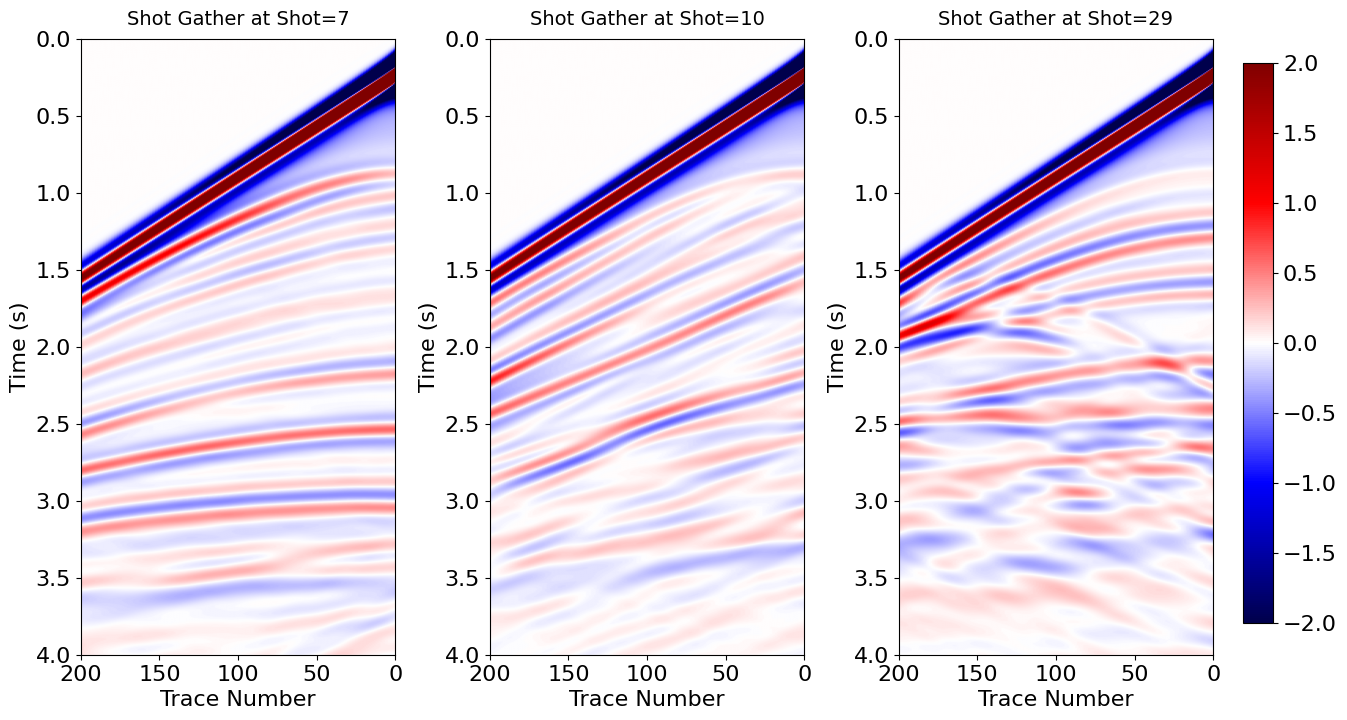

In [9]:
d_obs = [r for r, _ in fm]
plot_shotrecord_cust(d_obs[6].data, 'Shot Gather at Shot=7',
                     d_obs[14].data, 'Shot Gather at Shot=10',
                     d_obs[-4].data, 'Shot Gather at Shot=29',
                     model=model1,
                     t0=geometry1[0].t0,
                     tn=geometry1[0].tn,
                     save=False,
                     colorbar=True)


In [10]:
fpath = 'model_progress/marm_cg_1scale'

# Create wrapper
def loss_func(x, model_true, geoms, n_workers, client, d_true, blur, seis_loss):
    
    model_vp = x.reshape(model_true.shape)

    model_up = get_model(model_vp, shape, spacing, origin)
    
    client.restart()
    loss, grad = grad_multi_shots(model_true, model_up, geoms, n_workers, client, d_true, blur)
    seis_loss.append(loss)
    np.savetxt(f'{fpath}/loss_monitor.txt', seis_loss)
    np.savetxt(f'{fpath}/grad_monitor.txt', grad)
    return loss, grad.flatten().astype(np.float64)


# Callback to track model misfit
def fwi_callback(xk, fpath):

    update_vp = xk.reshape(model_true.shape)
    update_vp = np.clip(update_vp, minv, maxv)

    # Save first update and monitor model   
    first_model_path = f'{fpath}/first_model.txt'
    if not os.path.exists(first_model_path):
        np.savetxt(f'{fpath}/first_model.txt', update_vp)
    else:
        np.savetxt(f'{fpath}/model_monitor.txt', update_vp)
    

In [11]:
from scipy import optimize

# FWI with Conjugate Gradient

nbl = model1.nbl
model_true = model1
model_init = model0
geoms = geometry1.copy()
d_true = d_obs.copy()

vp_true = model1.vp.data[nbl:-nbl, nbl:-nbl]
seis_loss, vp_error = [], []
vp_tmp = [0, ]

ftol = 10e-10
gtol = 10e-10
maxiter = 50
maxls = 10
blur = 3

# Initial guess
v0 = model_init.vp.data[nbl:-nbl, nbl:-nbl]
m0 = v0.reshape(-1).astype(np.float64)

# Box contraints
vmin = v.min()   
vmax = v.max()
bounds = [(vmin, vmax) for _ in range(np.prod(model0.shape))]

start_inv = time.time()
client.restart()
res = optimize.minimize(loss_func, m0, 
                        args=(model_true, geoms, n_workers, client, d_true, blur, seis_loss), 
                        method='CG', 
                        jac=True, 
                        callback=lambda x: fwi_callback(x, fpath), 
                        bounds=bounds, 
                        options={'maxiter':maxiter, 
                                 'gtol'   :gtol,
                                 'disp'   :True}
                       )
finish_inv = time.time()

# Store model, gradient, and misfit value
model_vp_optim1 = res.x.reshape(model1.shape)
np.savetxt(f'{fpath}/model_final.txt', model_vp_optim1)
model1_devito = get_model(model_vp_optim1, shape, spacing, origin)

grad_optim1 = res.jac.reshape(model1.shape)
np.savetxt(f'{fpath}/grad_final.txt', grad_optim1)
np.savetxt(f'{fpath}/misfit_final.txt', vp_error)

duration_inv = finish_inv - start_inv

/tmp/ipykernel_604/3473934962.py:32: RuntimeWarning: Method CG cannot handle bounds.
  res = optimize.minimize(loss_func, m0,
/home/jovyan/work/devito_ta/simulation.py:107: UserWarning: Sending large graph of size 12.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  futures.append(client.submit(grad_x_shot,
Operator `Forward` ran in 2.06 s
Operator `Forward` ran in 2.01 s
Operator `Forward` ran in 1.85 s
Operator `Forward` ran in 2.33 s
Operator `Gradient` ran in 2.98 s
Operator `Gradient` ran in 2.87 s
Operator `Gradient` ran in 2.81 s
Operator `Forward` ran in 11.06 s
Operator `Gradient` ran in 7.88 s
Operator `Forward` ran in 13.37 s
Operator `Gradient` ran in 7.75 s
Operator `Gradient` ran in 5.94 s
2025-09-11 10:32:16,286 - distributed.worker.memory - WARNI

         Current function value: 3463.311523
         Iterations: 50
         Function evaluations: 136
         Gradient evaluations: 136


In [12]:
print(f'Duration for inversion with Conjugate Gradient: {(duration_inv/3600):.2f} hrs')

Duration for inversion with Conjugate Gradient: 3.55 hrs
